In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

In [3]:
def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [4]:
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)


In [5]:
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [6]:
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [7]:
from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

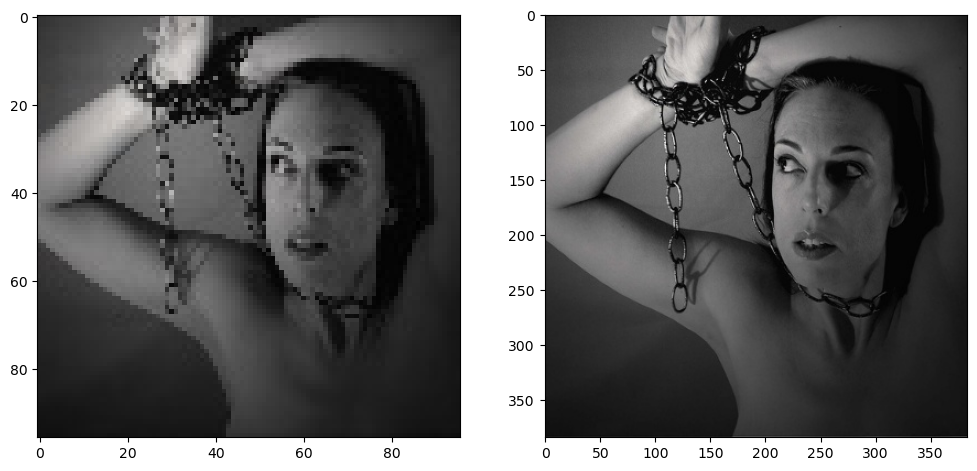



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 96, 96, 64)           15616     ['input_1[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 96, 96, 64)           64        ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 96, 96, 64)           36928     ['p_re_lu[0][0]']             
                                                                                            

 chNormalization)                                                                                 
                                                                                                  
 p_re_lu_5 (PReLU)           (None, 96, 96, 64)           64        ['batch_normalization_8[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 96, 96, 64)           36928     ['p_re_lu_5[0][0]']           
                                                                                                  
 batch_normalization_9 (Bat  (None, 96, 96, 64)           256       ['conv2d_10[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 add_4 (Ad

                                                                                                  
 batch_normalization_18 (Ba  (None, 96, 96, 64)           256       ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 p_re_lu_10 (PReLU)          (None, 96, 96, 64)           64        ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 96, 96, 64)           36928     ['p_re_lu_10[0][0]']          
                                                                                                  
 batch_normalization_19 (Ba  (None, 96, 96, 64)           256       ['conv2d_20[0][0]']           
 tchNormal

                                                                                                  
 conv2d_29 (Conv2D)          (None, 96, 96, 64)           36928     ['add_13[0][0]']              
                                                                                                  
 batch_normalization_28 (Ba  (None, 96, 96, 64)           256       ['conv2d_29[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 p_re_lu_15 (PReLU)          (None, 96, 96, 64)           64        ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_30 (Conv2D)          (None, 96, 96, 64)           36928     ['p_re_lu_15[0][0]']          
          

                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 96, 96, 128)       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 96, 96, 256)       295168    
                                                                 
 batch_normalization_36 (Ba  (None, 96, 96, 256)       1024      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 96, 96, 256)       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 48, 48, 256)       590080    
                                                                 
 batch_normalization_37 (Ba  (None, 48, 48, 256)       1024      
 tchNormalization)                                               
                                                                 
 leaky_re_

In [8]:
n=5000
lr_list = os.listdir("data/lr_images_1")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("data/lr_images_1/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir("data/hr_images_1")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("data/hr_images_1/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (96, 96, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (384, 384, 3)))
plt.show()

#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

In [9]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 model (Functional)          (None, 384, 384, 3)          2044291   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 384, 384, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 1)                    3066847   ['model[0][0]']               
                                                          37                                

In [10]:
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [ ]:
epochs = 3000
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 3000 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e) +".h5")

  0%|                                                                                         | 0/3350 [00:00<?, ?it/s]



1/1 [==============================] - 0s 126ms/step


  0%|                                                                              | 1/3350 [00:19<17:47:44, 19.13s/it]

1/1 [==============================] - 0s 42ms/step


  0%|                                                                               | 2/3350 [00:20<8:05:34,  8.70s/it]

1/1 [==============================] - 0s 47ms/step


  0%|                                                                               | 3/3350 [00:21<4:57:47,  5.34s/it]

1/1 [==============================] - 0s 47ms/step


  0%|                                                                               | 4/3350 [00:23<3:29:42,  3.76s/it]

1/1 [==============================] - 0s 47ms/step


  0%|                                                                               | 5/3350 [00:24<2:39:21,  2.86s/it]

1/1 [==============================] - 0s 47ms/step


  0%|▏                                                                              | 6/3350 [00:25<2:08:59,  2.31s/it]

1/1 [==============================] - 0s 32ms/step


  0%|▏                                                                              | 7/3350 [00:27<1:50:47,  1.99s/it]

1/1 [==============================] - 0s 51ms/step


  0%|▏                                                                              | 8/3350 [00:28<1:40:33,  1.81s/it]

1/1 [==============================] - 0s 47ms/step


  0%|▏                                                                              | 9/3350 [00:29<1:31:59,  1.65s/it]

1/1 [==============================] - 0s 50ms/step


  0%|▏                                                                             | 10/3350 [00:31<1:26:11,  1.55s/it]

1/1 [==============================] - 0s 47ms/step


  0%|▎                                                                             | 11/3350 [00:32<1:22:43,  1.49s/it]

1/1 [==============================] - 0s 47ms/step


  0%|▎                                                                             | 12/3350 [00:33<1:18:59,  1.42s/it]

1/1 [==============================] - 0s 56ms/step


  0%|▎                                                                             | 13/3350 [00:35<1:17:53,  1.40s/it]

1/1 [==============================] - 0s 32ms/step


  0%|▎                                                                             | 14/3350 [00:36<1:15:47,  1.36s/it]

1/1 [==============================] - 0s 58ms/step


  0%|▎                                                                             | 15/3350 [00:37<1:17:57,  1.40s/it]

1/1 [==============================] - 0s 47ms/step


  0%|▎                                                                             | 16/3350 [00:39<1:15:48,  1.36s/it]

1/1 [==============================] - 0s 53ms/step


  1%|▍                                                                             | 17/3350 [00:40<1:15:34,  1.36s/it]

1/1 [==============================] - 0s 56ms/step


  1%|▍                                                                             | 18/3350 [00:41<1:16:58,  1.39s/it]

1/1 [==============================] - 0s 59ms/step


  1%|▍                                                                             | 19/3350 [00:43<1:19:12,  1.43s/it]

1/1 [==============================] - 0s 47ms/step


  1%|▍                                                                             | 20/3350 [00:44<1:17:56,  1.40s/it]

1/1 [==============================] - 0s 47ms/step


  1%|▍                                                                             | 21/3350 [00:46<1:15:10,  1.35s/it]

1/1 [==============================] - 0s 37ms/step


  1%|▌                                                                             | 22/3350 [00:47<1:14:24,  1.34s/it]

1/1 [==============================] - 0s 53ms/step


  1%|▌                                                                             | 23/3350 [00:48<1:15:27,  1.36s/it]

1/1 [==============================] - 0s 59ms/step


  1%|▌                                                                             | 24/3350 [00:50<1:16:09,  1.37s/it]

1/1 [==============================] - 0s 33ms/step


  1%|▌                                                                             | 25/3350 [00:51<1:16:03,  1.37s/it]

1/1 [==============================] - 0s 54ms/step


  1%|▌                                                                             | 26/3350 [00:52<1:16:34,  1.38s/it]

1/1 [==============================] - 0s 66ms/step


  1%|▋                                                                             | 27/3350 [00:54<1:17:02,  1.39s/it]

1/1 [==============================] - 0s 52ms/step


  1%|▋                                                                             | 28/3350 [00:55<1:15:44,  1.37s/it]

1/1 [==============================] - 0s 63ms/step


  1%|▋                                                                             | 29/3350 [00:57<1:17:07,  1.39s/it]

1/1 [==============================] - 0s 63ms/step


  1%|▋                                                                             | 30/3350 [00:58<1:17:49,  1.41s/it]

1/1 [==============================] - 0s 66ms/step


  1%|▋                                                                             | 31/3350 [01:00<1:19:32,  1.44s/it]

1/1 [==============================] - 0s 98ms/step


  1%|▋                                                                             | 32/3350 [01:01<1:22:36,  1.49s/it]

1/1 [==============================] - 0s 47ms/step


  1%|▊                                                                             | 33/3350 [01:02<1:18:47,  1.43s/it]

1/1 [==============================] - 0s 31ms/step


  1%|▊                                                                             | 34/3350 [01:04<1:15:36,  1.37s/it]

1/1 [==============================] - 0s 31ms/step


  1%|▊                                                                             | 35/3350 [01:05<1:13:46,  1.34s/it]

1/1 [==============================] - 0s 31ms/step


  1%|▊                                                                             | 36/3350 [01:06<1:12:12,  1.31s/it]

1/1 [==============================] - 0s 47ms/step


  1%|▊                                                                             | 37/3350 [01:07<1:11:28,  1.29s/it]

1/1 [==============================] - 0s 47ms/step


  1%|▉                                                                             | 38/3350 [01:09<1:10:52,  1.28s/it]

1/1 [==============================] - 0s 47ms/step


  1%|▉                                                                             | 39/3350 [01:10<1:09:55,  1.27s/it]

1/1 [==============================] - 0s 31ms/step


  1%|▉                                                                             | 40/3350 [01:11<1:09:23,  1.26s/it]

1/1 [==============================] - 0s 31ms/step


  1%|▉                                                                             | 41/3350 [01:12<1:09:36,  1.26s/it]

1/1 [==============================] - 0s 31ms/step


  1%|▉                                                                             | 42/3350 [01:14<1:09:05,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  1%|█                                                                             | 43/3350 [01:15<1:09:11,  1.26s/it]

1/1 [==============================] - 0s 31ms/step


  1%|█                                                                             | 44/3350 [01:16<1:08:34,  1.24s/it]

1/1 [==============================] - 0s 47ms/step


  1%|█                                                                             | 45/3350 [01:17<1:08:49,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  1%|█                                                                             | 46/3350 [01:19<1:08:54,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  1%|█                                                                             | 47/3350 [01:20<1:08:14,  1.24s/it]

1/1 [==============================] - 0s 47ms/step


  1%|█                                                                             | 48/3350 [01:21<1:08:40,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  1%|█▏                                                                            | 49/3350 [01:22<1:08:26,  1.24s/it]

1/1 [==============================] - 0s 47ms/step


  1%|█▏                                                                            | 50/3350 [01:24<1:08:22,  1.24s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▏                                                                            | 51/3350 [01:25<1:08:22,  1.24s/it]

1/1 [==============================] - 0s 64ms/step


  2%|█▏                                                                            | 52/3350 [01:26<1:09:34,  1.27s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▏                                                                            | 53/3350 [01:27<1:09:26,  1.26s/it]

1/1 [==============================] - 0s 31ms/step


  2%|█▎                                                                            | 54/3350 [01:29<1:09:07,  1.26s/it]

1/1 [==============================] - 0s 31ms/step


  2%|█▎                                                                            | 55/3350 [01:30<1:08:54,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▎                                                                            | 56/3350 [01:31<1:08:42,  1.25s/it]

1/1 [==============================] - 0s 31ms/step


  2%|█▎                                                                            | 57/3350 [01:32<1:08:33,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▎                                                                            | 58/3350 [01:34<1:08:32,  1.25s/it]

1/1 [==============================] - 0s 31ms/step


  2%|█▎                                                                            | 59/3350 [01:35<1:08:26,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▍                                                                            | 60/3350 [01:36<1:08:26,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▍                                                                            | 61/3350 [01:37<1:08:26,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▍                                                                            | 62/3350 [01:39<1:08:47,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▍                                                                            | 63/3350 [01:40<1:08:32,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▍                                                                            | 64/3350 [01:41<1:08:46,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▌                                                                            | 65/3350 [01:42<1:09:31,  1.27s/it]

1/1 [==============================] - 0s 63ms/step


  2%|█▌                                                                            | 66/3350 [01:44<1:09:40,  1.27s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▌                                                                            | 67/3350 [01:45<1:09:37,  1.27s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▌                                                                            | 68/3350 [01:46<1:09:12,  1.27s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▌                                                                            | 69/3350 [01:48<1:09:19,  1.27s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▋                                                                            | 70/3350 [01:49<1:09:20,  1.27s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▋                                                                            | 71/3350 [01:50<1:09:22,  1.27s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▋                                                                            | 72/3350 [01:51<1:09:14,  1.27s/it]

1/1 [==============================] - 0s 48ms/step


  2%|█▋                                                                            | 73/3350 [01:53<1:08:47,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▋                                                                            | 74/3350 [01:54<1:08:28,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▋                                                                            | 75/3350 [01:55<1:08:33,  1.26s/it]

1/1 [==============================] - 0s 48ms/step


  2%|█▊                                                                            | 76/3350 [01:56<1:08:25,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▊                                                                            | 77/3350 [01:58<1:08:26,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▊                                                                            | 78/3350 [01:59<1:08:21,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▊                                                                            | 79/3350 [02:00<1:08:08,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▊                                                                            | 80/3350 [02:01<1:08:08,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▉                                                                            | 81/3350 [02:03<1:08:06,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  2%|█▉                                                                            | 82/3350 [02:04<1:07:53,  1.25s/it]

1/1 [==============================] - 0s 31ms/step


  2%|█▉                                                                            | 83/3350 [02:05<1:07:32,  1.24s/it]

1/1 [==============================] - 0s 47ms/step


  3%|█▉                                                                            | 84/3350 [02:06<1:07:39,  1.24s/it]

1/1 [==============================] - 0s 47ms/step


  3%|█▉                                                                            | 85/3350 [02:08<1:08:34,  1.26s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██                                                                            | 86/3350 [02:09<1:09:07,  1.27s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██                                                                            | 87/3350 [02:10<1:09:13,  1.27s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██                                                                            | 88/3350 [02:11<1:08:47,  1.27s/it]

1/1 [==============================] - 0s 31ms/step


  3%|██                                                                            | 89/3350 [02:13<1:08:32,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██                                                                            | 90/3350 [02:14<1:08:24,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██                                                                            | 91/3350 [02:15<1:08:29,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▏                                                                           | 92/3350 [02:16<1:07:55,  1.25s/it]

1/1 [==============================] - 0s 31ms/step


  3%|██▏                                                                           | 93/3350 [02:18<1:07:48,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▏                                                                           | 94/3350 [02:19<1:07:54,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▏                                                                           | 95/3350 [02:20<1:08:05,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▏                                                                           | 96/3350 [02:21<1:07:53,  1.25s/it]

1/1 [==============================] - 0s 31ms/step


  3%|██▎                                                                           | 97/3350 [02:23<1:07:34,  1.25s/it]

1/1 [==============================] - 0s 63ms/step


  3%|██▎                                                                           | 98/3350 [02:24<1:07:45,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▎                                                                           | 99/3350 [02:25<1:07:34,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▎                                                                          | 100/3350 [02:26<1:07:30,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▎                                                                          | 101/3350 [02:28<1:07:25,  1.25s/it]

1/1 [==============================] - 0s 31ms/step


  3%|██▎                                                                          | 102/3350 [02:29<1:07:22,  1.24s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▎                                                                          | 103/3350 [02:30<1:07:07,  1.24s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▍                                                                          | 104/3350 [02:31<1:07:15,  1.24s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▍                                                                          | 105/3350 [02:33<1:07:36,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▍                                                                          | 106/3350 [02:34<1:07:56,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▍                                                                          | 107/3350 [02:35<1:07:45,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▍                                                                          | 108/3350 [02:36<1:07:48,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▌                                                                          | 109/3350 [02:38<1:07:26,  1.25s/it]

1/1 [==============================] - 0s 31ms/step


  3%|██▌                                                                          | 110/3350 [02:39<1:07:28,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▌                                                                          | 111/3350 [02:40<1:07:27,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▌                                                                          | 112/3350 [02:41<1:07:25,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▌                                                                          | 113/3350 [02:43<1:07:33,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▌                                                                          | 114/3350 [02:44<1:07:29,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▋                                                                          | 115/3350 [02:45<1:07:06,  1.24s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▋                                                                          | 116/3350 [02:46<1:07:16,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  3%|██▋                                                                          | 117/3350 [02:48<1:07:31,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  4%|██▋                                                                          | 118/3350 [02:49<1:07:34,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  4%|██▋                                                                          | 119/3350 [02:50<1:07:53,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  4%|██▊                                                                          | 120/3350 [02:51<1:08:02,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  4%|██▊                                                                          | 121/3350 [02:53<1:07:55,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  4%|██▊                                                                          | 122/3350 [02:54<1:07:27,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  4%|██▊                                                                          | 123/3350 [02:55<1:07:10,  1.25s/it]

1/1 [==============================] - 0s 31ms/step


  4%|██▊                                                                          | 124/3350 [02:56<1:07:45,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  4%|██▊                                                                          | 125/3350 [02:58<1:07:32,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  4%|██▉                                                                          | 126/3350 [02:59<1:07:41,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  4%|██▉                                                                          | 127/3350 [03:00<1:07:35,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  4%|██▉                                                                          | 128/3350 [03:02<1:07:40,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  4%|██▉                                                                          | 129/3350 [03:03<1:07:27,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  4%|██▉                                                                          | 130/3350 [03:04<1:07:40,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███                                                                          | 131/3350 [03:05<1:07:49,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███                                                                          | 132/3350 [03:07<1:07:33,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███                                                                          | 133/3350 [03:08<1:07:31,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███                                                                          | 134/3350 [03:09<1:07:11,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███                                                                          | 135/3350 [03:10<1:07:29,  1.26s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▏                                                                         | 136/3350 [03:12<1:07:17,  1.26s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▏                                                                         | 137/3350 [03:13<1:07:18,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███▏                                                                         | 138/3350 [03:14<1:07:37,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███▏                                                                         | 139/3350 [03:15<1:07:30,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███▏                                                                         | 140/3350 [03:17<1:07:17,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███▏                                                                         | 141/3350 [03:18<1:07:21,  1.26s/it]

1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                         | 142/3350 [03:19<1:07:11,  1.26s/it]

1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                         | 143/3350 [03:20<1:06:54,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███▎                                                                         | 144/3350 [03:22<1:06:52,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███▎                                                                         | 145/3350 [03:23<1:06:57,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███▎                                                                         | 146/3350 [03:24<1:07:02,  1.26s/it]

1/1 [==============================] - 0s 63ms/step


  4%|███▍                                                                         | 147/3350 [03:25<1:07:00,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███▍                                                                         | 148/3350 [03:27<1:07:34,  1.27s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███▍                                                                         | 149/3350 [03:28<1:07:23,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  4%|███▍                                                                         | 150/3350 [03:29<1:07:16,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▍                                                                         | 151/3350 [03:30<1:07:25,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▍                                                                         | 152/3350 [03:32<1:07:08,  1.26s/it]

1/1 [==============================] - 0s 63ms/step


  5%|███▌                                                                         | 153/3350 [03:33<1:07:10,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▌                                                                         | 154/3350 [03:34<1:07:12,  1.26s/it]

1/1 [==============================] - 0s 63ms/step


  5%|███▌                                                                         | 155/3350 [03:36<1:07:09,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▌                                                                         | 156/3350 [03:37<1:07:42,  1.27s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▌                                                                         | 157/3350 [03:38<1:07:20,  1.27s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▋                                                                         | 158/3350 [03:39<1:07:03,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▋                                                                         | 159/3350 [03:41<1:06:36,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▋                                                                         | 160/3350 [03:42<1:06:34,  1.25s/it]

1/1 [==============================] - 0s 31ms/step


  5%|███▋                                                                         | 161/3350 [03:43<1:06:31,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▋                                                                         | 162/3350 [03:44<1:06:29,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▋                                                                         | 163/3350 [03:46<1:07:05,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▊                                                                         | 164/3350 [03:47<1:06:57,  1.26s/it]

1/1 [==============================] - 0s 31ms/step


  5%|███▊                                                                         | 165/3350 [03:48<1:06:33,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▊                                                                         | 166/3350 [03:49<1:06:14,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▊                                                                         | 167/3350 [03:51<1:06:22,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▊                                                                         | 168/3350 [03:52<1:06:21,  1.25s/it]

1/1 [==============================] - 0s 31ms/step


  5%|███▉                                                                         | 169/3350 [03:53<1:06:03,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▉                                                                         | 170/3350 [03:54<1:06:11,  1.25s/it]

1/1 [==============================] - 0s 31ms/step


  5%|███▉                                                                         | 171/3350 [03:56<1:05:59,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▉                                                                         | 172/3350 [03:57<1:05:49,  1.24s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▉                                                                         | 173/3350 [03:58<1:05:48,  1.24s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▉                                                                         | 174/3350 [03:59<1:06:29,  1.26s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████                                                                         | 175/3350 [04:01<1:06:20,  1.25s/it]

1/1 [==============================] - 0s 63ms/step


  5%|████                                                                         | 176/3350 [04:02<1:06:16,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  5%|████                                                                         | 177/3350 [04:03<1:06:12,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  5%|████                                                                         | 178/3350 [04:04<1:06:14,  1.25s/it]

1/1 [==============================] - 0s 31ms/step


  5%|████                                                                         | 179/3350 [04:06<1:06:04,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  5%|████▏                                                                        | 180/3350 [04:07<1:05:54,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  5%|████▏                                                                        | 181/3350 [04:08<1:05:55,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  5%|████▏                                                                        | 182/3350 [04:09<1:06:04,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  5%|████▏                                                                        | 183/3350 [04:11<1:05:55,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  5%|████▏                                                                        | 184/3350 [04:12<1:06:02,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▎                                                                        | 185/3350 [04:13<1:06:05,  1.25s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▎                                                                        | 186/3350 [04:14<1:06:10,  1.25s/it]

1/1 [==============================] - 0s 31ms/step


  6%|████▎                                                                        | 187/3350 [04:16<1:06:19,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▎                                                                        | 188/3350 [04:17<1:06:12,  1.26s/it]

1/1 [==============================] - 0s 31ms/step


  6%|████▎                                                                        | 189/3350 [04:18<1:05:57,  1.25s/it]

1/1 [==============================] - 0s 48ms/step


  6%|████▎                                                                        | 190/3350 [04:19<1:07:18,  1.28s/it]

1/1 [==============================] - 0s 70ms/step


  6%|████▍                                                                        | 191/3350 [04:21<1:10:35,  1.34s/it]

1/1 [==============================] - 0s 70ms/step


  6%|████▍                                                                        | 192/3350 [04:23<1:14:29,  1.42s/it]

1/1 [==============================] - 0s 58ms/step


  6%|████▍                                                                        | 193/3350 [04:24<1:16:40,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▍                                                                        | 194/3350 [04:26<1:17:36,  1.48s/it]

1/1 [==============================] - 0s 59ms/step


  6%|████▍                                                                        | 195/3350 [04:27<1:17:45,  1.48s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▌                                                                        | 196/3350 [04:29<1:17:51,  1.48s/it]

1/1 [==============================] - 0s 73ms/step


  6%|████▌                                                                        | 197/3350 [04:30<1:18:56,  1.50s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▌                                                                        | 198/3350 [04:31<1:16:08,  1.45s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▌                                                                        | 199/3350 [04:33<1:13:31,  1.40s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▌                                                                        | 200/3350 [04:34<1:11:44,  1.37s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▌                                                                        | 201/3350 [04:35<1:10:12,  1.34s/it]

1/1 [==============================] - 0s 32ms/step


  6%|████▋                                                                        | 202/3350 [04:37<1:09:21,  1.32s/it]

1/1 [==============================] - 0s 57ms/step


  6%|████▋                                                                        | 203/3350 [04:38<1:10:50,  1.35s/it]

1/1 [==============================] - 0s 72ms/step


  6%|████▋                                                                        | 204/3350 [04:39<1:11:44,  1.37s/it]

1/1 [==============================] - 0s 43ms/step


  6%|████▋                                                                        | 205/3350 [04:41<1:10:52,  1.35s/it]

1/1 [==============================] - 0s 47ms/step


  6%|████▋                                                                        | 206/3350 [04:42<1:09:11,  1.32s/it]

1/1 [==============================] - 0s 43ms/step


  6%|████▊                                                                        | 207/3350 [04:43<1:09:06,  1.32s/it]

1/1 [==============================] - 0s 56ms/step


  6%|████▊                                                                        | 208/3350 [04:45<1:08:21,  1.31s/it]

1/1 [==============================] - 0s 55ms/step


  6%|████▊                                                                        | 209/3350 [04:46<1:08:42,  1.31s/it]

1/1 [==============================] - 0s 63ms/step


  6%|████▊                                                                        | 210/3350 [04:47<1:08:15,  1.30s/it]

1/1 [==============================] - 0s 66ms/step


  6%|████▊                                                                        | 211/3350 [04:49<1:11:28,  1.37s/it]

1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


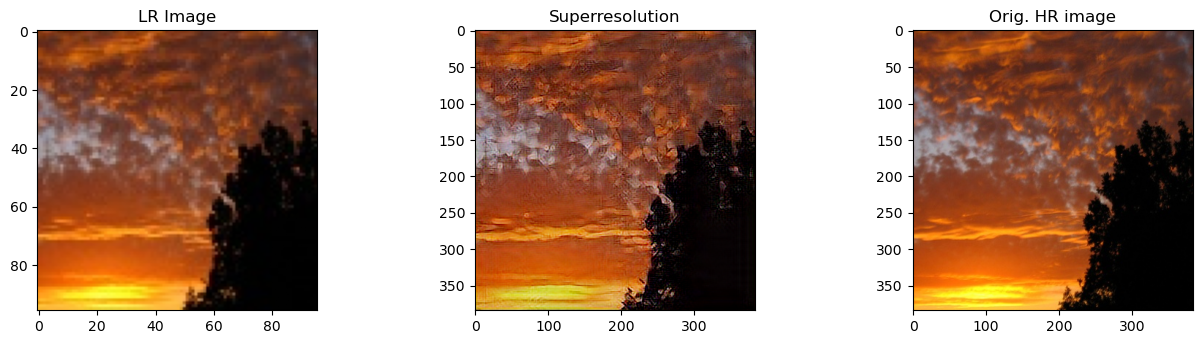

In [11]:
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen_e_3000.h5', compile=False)

[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()
